# Finetuning Stable Diffusion

In [1]:
# fix locale, to prevent future flaky errors

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.9 MB/s eta 0:00:00


In [3]:
# import libraries

import os
import torch
import numpy as np

from diffusers import StableDiffusionPipeline
from PIL import Image
from scipy.spatial.distance import cosine
from transformers import BlipProcessor, BlipForConditionalGeneration

In [4]:
# create folders if they don't exist already

folder_names = ['embeddings', 'images', 'models']

# check and create folders if they don't exist
for folder_name in folder_names:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created.")
    else:
        print(f"Folder '{folder_name}' already exists.")

Folder 'embeddings' created.
Folder 'images' created.
Folder 'models' created.


For this to work we need a specific use case so we can use images of it. Since I found a cool dataset that has images of Pokemon with a BLIP generated caption of it. Also who doesn't like Pokemon?

Data Source: https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions

Install training scripts and dependencies:

In [5]:
!git clone https://github.com/huggingface/diffusers
!pip install ./diffusers
!pip install -r ./diffusers/examples/text_to_image/requirements.txt

Cloning into 'diffusers'...
remote: Enumerating objects: 29221, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 29221 (delta 30), reused 46 (delta 19), pack-reused 29158
Receiving objects: 100% (29221/29221), 33.28 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (21295/21295), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.17.0.dev0-py3-none-any.whl size=1073751 sha256=723d4f08efd5fff00deb14d2e64fad2ccceae7bf8ba3ef893397025a794db11f
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6mfdj97/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.5 MB/s eta 0:00:00


In [6]:
!accelerate config default

2023-06-03 07:24:14.725596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Login to Huggingface
For this to work you need a Huggingface Account, then open [this url](https://huggingface.co/settings/tokens), create an acces token and enter it in the prompt below:

In [7]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# With LoRA

In [8]:
!accelerate launch --mixed_precision="fp16" diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4" \
  --dataset_name="lambdalabs/pokemon-blip-captions" --caption_column="text" \
  --resolution=512 --random_flip \
  --train_batch_size=1 \
  --num_train_epochs=50 --checkpointing_steps=5000 \
  --learning_rate=1e-04 --lr_scheduler="constant" --lr_warmup_steps=0 \
  --seed=42 \
  --output_dir="sd-pokemon-model-lora" \
  --validation_prompt="cute dragon creature"

2023-06-03 07:26:38.032810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-03 07:26:43.050364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
06/03/2023 07:26:44 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'variance_type', 'prediction_type', 'dynamic_thresholding_ratio', 'clip_sample_range', 'thresholding', 'sample_max_value'} was not found in config. Values will be initialized to default values.
{'norm_num_groups'} was not found in config. Values will be initialized to default values.
{'upcast_attention', 'mid_block_type', 'timestep_post_act', 'only_cross_attention', 'r

The finetuning is done, let's do a quick test:

## Inference:

In [9]:
pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)
pipe.unet.load_attn_procs('./sd-pokemon-model-lora/pytorch_lora_weights.bin')

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

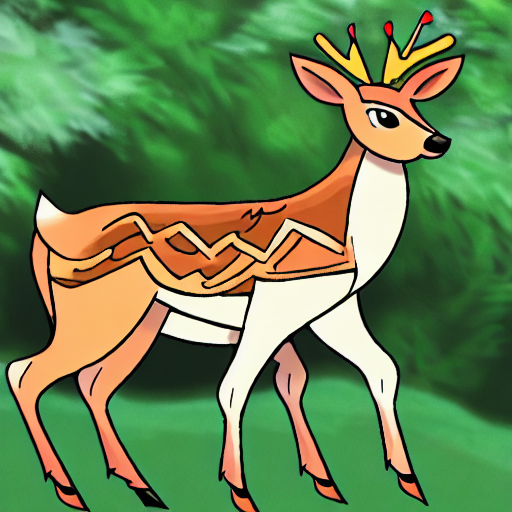

In [12]:
pipe.to('cuda')

image = pipe(prompt='a deer with leafs').images[0]
image.save('images/image1.png')
image.show()

  0%|          | 0/50 [00:00<?, ?it/s]

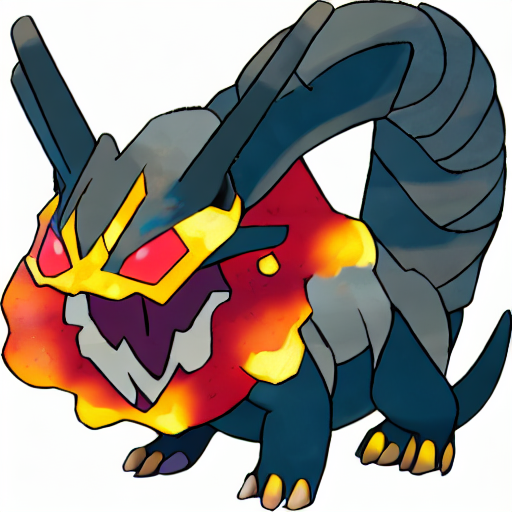

In [11]:
image = pipe(prompt='a dragon with fire').images[0]
image.save('images/image2.png')
image.show()

Our results really look like Pokemons :D. We can now download the finetuned model and use it in the next notebook to evaluate our results. Please continue in the 03_results_and_conclusions.ipynb